In [1]:
#Import base overlay
from pynq.overlays.base import BaseOverlay
base = BaseOverlay("/usr/local/lib/python3.6/dist-packages/pynq/overlays/base/base.bit")
pAudio = base.audio

In [2]:
pAudio.select_microphone()
pAudio.bypass(seconds=5)

In [19]:
#Record audio and save as .wav file
pAudio.record(6)
pAudio.save("test_audio.wav")

In [20]:
#Audio playback
pAudio.load("test_audio.wav")
pAudio.play()

In [5]:
#.wav file properties
import wave as we
f = we.open("hello_noise.wav")
params = f.getparams()
print(params)
f.close()

_wave_params(nchannels=2, sampwidth=3, framerate=48000, nframes=240000, comptype='NONE', compname='not compressed')


In [6]:
import wave
import numpy as np
import matplotlib.pyplot as plt
from scipy.io.wavfile import write

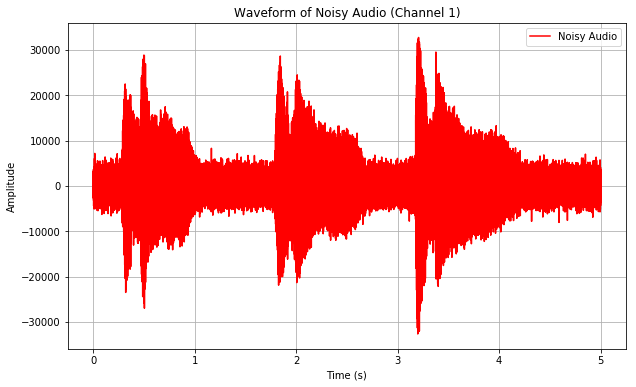

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io.wavfile import write
import wave

# Function to convert 24-bit audio to a numpy array
def convert_24bit_to_int32(data):
    """Convert 24-bit audio data to 32-bit integer."""
    data = np.frombuffer(data, dtype=np.uint8)  # Read as bytes
    # Reshape and combine bytes to form 32-bit integers
    data = data.reshape(-1, 3)
    int_data = (data[:, 0].astype(np.int32) |
                (data[:, 1].astype(np.int32) << 8) |
                (data[:, 2].astype(np.int32) << 16))
    # Handle signed 24-bit range
    int_data[int_data >= 2**23] -= 2**24
    return int_data

# Load the .wav file
with wave.open('hello_noise.wav', 'rb') as wav_file:
    nchannels, sampwidth, framerate, nframes, comptype, compname = wav_file.getparams()
    frames = wav_file.readframes(nframes)

    # Process 24-bit audio
    if sampwidth == 3:  # For 24-bit
        audio_data = convert_24bit_to_int32(frames)
    else:  # For other bit depths
        dtype = np.int16 if sampwidth == 2 else np.int8
        audio_data = np.frombuffer(frames, dtype=dtype)
    
    # Reshape based on number of channels
    audio_data = audio_data.reshape(-1, nchannels)

# Select a single channel (e.g., channel 0)
single_channel_data = audio_data[:, 0]

# Normalize the audio data to 16-bit range
max_amplitude = np.max(np.abs(single_channel_data))
normalized_data = (single_channel_data / max_amplitude * 32767).astype(np.int16)

# Add noise to the normalized data
def add_noise_to_audio(audio_data, noise_level=0.02):
    """Add Gaussian noise to audio data."""
    noise = np.random.normal(0, noise_level * 32767, len(audio_data))  # Gaussian noise
    noisy_audio = audio_data + noise.astype(np.int16)
    
    # Ensure the audio is within the 16-bit range
    noisy_audio = np.clip(noisy_audio, -32768, 32767)
    
    return noisy_audio

# Add noise to the normalized audio data
noisy_audio_data = add_noise_to_audio(normalized_data, noise_level=0.05)

# Create a time axis for plotting the noisy audio
time_axis = np.linspace(0, len(single_channel_data) / framerate, num=len(single_channel_data))

# Plot the waveform of the noisy audio
plt.figure(figsize=(10, 6))
plt.plot(time_axis, noisy_audio_data, label='Noisy Audio', color='red')
plt.title('Waveform of Noisy Audio (Channel 1)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

# Save the noisy audio as a new .wav file
output_filename = 'output_noisy_audio.wav'
write(output_filename, framerate, noisy_audio_data)

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
import wave as we
import math
import ctypes as ct  #C compatible data types


def read_wav(wavfile):
    f = wavfile
    params = f.getparams()

    nchannels, sampwidth, framerate, nframes = params[:4]
    strData = f.readframes(nframes)
    waveData = np.frombuffer(strData, dtype=np.int16)

    time = np.arange(0, nframes)*(1.0 / framerate)
    plt.plot(time, waveData)
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.title("Wavedata")
    plt.show()
    return (waveData, time)


class FloatBits(ct.Structure):
    _fields_ = [
        ('M', ct.c_uint, 23),       #unsigned int
        ('E', ct.c_uint, 8),
        ('S', ct.c_uint, 1)
    ]

class Float(ct.Union):
    _anonymous_ = ('bits',)
    _fields_ = [
        ('value', ct.c_float),
        ('bits', FloatBits)
    ]

def nextpow2(x):  #return smallest power of 2 greater than or equal to abs(x)
    if x < 0:
        x = -x
    if x == 0:
        return 0
    d = Float()
    d.value = x
    if d.M == 0:
        return d.E - 127
    return d.E - 127 + 1

# Open WAV file
f = we.open("output_channel1.wav")

# Read format information
# (nchannels, sampwidth, framerate, nframes, comptype, compname)
params = f.getparams()
nchannels, sampwidth, framerate, nframes = params[:4]
fs = framerate
# Reads the waveform data
str_data = f.readframes(nframes)
f.close()
 # Waveform data into an array
x = np.fromstring(str_data, dtype=np.short)
# Calculation parameters
len_ = 20 * fs // 1000  #Typically frames are taken to be about 20ms long
PERC = 50  #percent overlap
len1 = len_ * PERC // 100
len2 = len_ - len1
# Set the default parameters
Thres = 3
Expnt = 2.0
beta = 0.002
G = 0.9

# Initialize Hamming window to window each frame
win = np.hamming(len_)
# normalization gain for overlap+add with 50% overlap
winGain = len2 / sum(win)


# Noise magnitude calculations - assuming that the first 5 frames is noise/silence
nFFT = 2 * 2 ** (nextpow2(len_))
noise_mean = np.zeros(nFFT)

j = 0
for k in range(1, 6):
    noise_mean = noise_mean + abs(np.fft.fft(win * x[j:j + len_], nFFT))
    j = j + len_
noise_mu = noise_mean / 5


# --- allocate memory and initialize various variables
k = 1
img = 1j
x_old = np.zeros(len1)
Nframes = len(x) // len2 - 1
xfinal = np.zeros(Nframes * len2)


# =========================    Start Processing   ===============================
for n in range(0, Nframes):
    # Windowing
    insign = win * x[k-1:k + len_ - 1]
    # compute fourier transform of a frame
    spec = np.fft.fft(insign, nFFT)
    # compute the magnitude
    sig = abs(spec)
    # save the noisy phase information
    theta = np.angle(spec)
    SNRseg = 10 * np.log10(np.linalg.norm(sig, 2) ** 2 / np.linalg.norm(noise_mu, 2) ** 2)


    #SNR = signal to noise ratio
    def berouti(SNR):
        if -5.0 <= SNR <= 20.0:
            a = 4 - SNR * 3 / 20
        else:
            if SNR < -5.0:
                a = 5
            if SNR > 20:
                a = 1
        return a


    def berouti1(SNR):
        if -5.0 <= SNR <= 20.0:
            a = 3 - SNR * 2 / 20
        else:
            if SNR < -5.0:
                a = 4
            if SNR > 20:
                a = 1
        return a


    if Expnt == 1.0: # magnitude spectrum
        alpha = berouti1(SNRseg)
    else: # the power spectrum
        alpha = berouti(SNRseg)

    #spectral subtraction
    sub_speech = sig ** Expnt - alpha * noise_mu ** Expnt;
         # Signal is smaller than the power when the pure noise signal
    diffw = sub_speech - beta * noise_mu ** Expnt
    # beta negative components


    def find_index(x_list):
        index_list = []
        for i in range(len(x_list)):
            if x_list[i] < 0:
                index_list.append(i)
        return index_list


    z = find_index(diffw)
    if len(z) > 0:
        # With lower estimated noise signal represents the limit
        sub_speech[z] = beta * noise_mu[z] ** Expnt
        # --- implement a simple VAD (voice activity detection) detector --------------
        if SNRseg < Thres:  # Update noise spectrum
            noise_temp = G * noise_mu ** Expnt + (1 - G) * sig ** Expnt # smoothing processing noise power spectrum
            noise_mu = noise_temp ** (1 / Expnt) # new noise amplitude spectrum
            # Flipud = turned upside down of a matrix of functions, based on the "horizontal line" axis of symmetry of the matrix
            #Vertically symmetrical switching elements
        sub_speech[nFFT // 2 + 1:nFFT] = np.flipud(sub_speech[1:nFFT // 2])
        x_phase = (sub_speech ** (1 / Expnt)) * (np.array([math.cos(x) for x in theta]) + img * (np.array([math.sin(x) for x in theta])))

        #Reconstructing the original signal
        # take the IFFT
        xi = np.fft.ifft(x_phase).real
        #Overlap and add
        xfinal[k-1:k + len2 - 1] = x_old + xi[0:len1]
        x_old = xi[0 + len1:len_]
        k = k + len2



/usr/lib/python3/dist-packages/ipykernel_launcher.py:63: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


In [9]:
import numpy as np

def rls_algorithm(x, d, num_taps, lambda_):
    """Recursive Least Squares (RLS) algorithm."""
    num_samples = len(x)
    w = np.zeros(num_taps)  # Filter weights
    P = np.eye(num_taps) * 1000  # Inverse correlation matrix (initially large)
    y = np.zeros(num_samples)  # Filter output
    e = np.zeros(num_samples)  # Error signal

    for n in range(num_taps, num_samples):
        x_n = x[n:n-num_taps:-1]  # Input vector
        y[n] = np.dot(w, x_n)  # Filter output
        e[n] = d[n] - y[n]  # Error signal
        k = np.dot(P, x_n) / (lambda_ + np.dot(x_n, np.dot(P, x_n)))  # Kalman gain
        w = w + k * e[n]  # Weight update
        P = (P - np.outer(k, np.dot(x_n, P))) / lambda_  # Update P

    return e, y

class ParticleSwarmOptimization:
    def __init__(self, num_particles, num_iterations, num_taps, x, d):
        self.num_particles = num_particles
        self.num_iterations = num_iterations
        self.num_taps = num_taps
        self.x = x
        self.d = d
        self.velocity = np.random.randn(num_particles, num_taps)
        self.position = np.random.randn(num_particles, num_taps)
        self.best_position = np.copy(self.position)
        self.best_value = np.inf * np.ones(num_particles)
        self.global_best_position = None
        self.global_best_value = np.inf
        self.c1 = 2  # Cognitive coefficient
        self.c2 = 2  # Social coefficient
        self.w = 0.5  # Inertia weight
    
    def fitness(self, position):
        """Fitness function for PSO. Here, we use MSE (Mean Squared Error) for optimization."""
        e, _ = lms_algorithm(self.x, self.d, position, self.num_taps)  # Use LMS for MSE calculation
        return np.mean(e**2)  # MSE error

    def optimize(self):
        for iteration in range(self.num_iterations):
            for i in range(self.num_particles):
                # Calculate the fitness (error) for each particle
                current_value = self.fitness(self.position[i])
                
                # Update the best individual position
                if current_value < self.best_value[i]:
                    self.best_value[i] = current_value
                    self.best_position[i] = self.position[i]
                    
                # Update the global best position
                if current_value < self.global_best_value:
                    self.global_best_value = current_value
                    self.global_best_position = self.position[i]
            
            # Update particle velocities and positions
            for i in range(self.num_particles):
                r1, r2 = np.random.rand(2)
                self.velocity[i] = (self.w * self.velocity[i] +
                                     self.c1 * r1 * (self.best_position[i] - self.position[i]) +
                                     self.c2 * r2 * (self.global_best_position - self.position[i]))
                self.position[i] += self.velocity[i]
        
        return self.global_best_position, self.global_best_value


Filtered Audio:


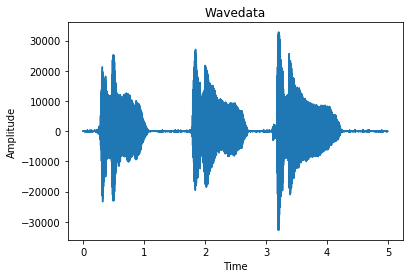

(array([ 11,  11,   9, ..., -31, -35, -43], dtype=int16),
 array([0.00000000e+00, 2.08333333e-05, 4.16666667e-05, ...,
        4.98993750e+00, 4.98995833e+00, 4.98997917e+00]))

In [22]:
# save document
wf = we.open('filtered_out.wav', 'wb')
# Setting parameters
wf.setparams(params)
# .toString wave file () to convert the data array
wave_data = (winGain * xfinal).astype(np.short)
wf.writeframes(wave_data.tostring())
wf.close()
f = we.open("filtered_out.wav", 'rb')
print("\nFiltered Audio:")
read_wav(f)

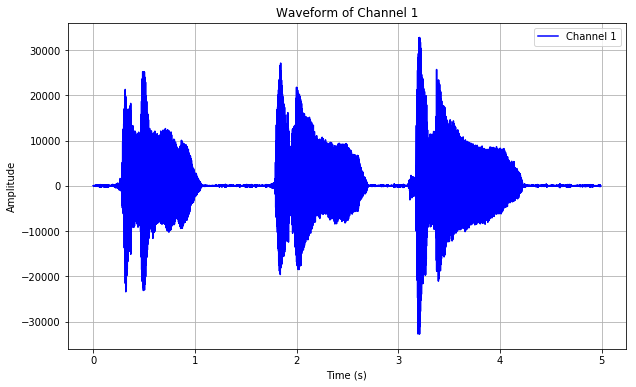

In [24]:
# Load the .wav file
with wave.open('filtered_out.wav', 'rb') as wav_file:
    nchannels, sampwidth, framerate, nframes, comptype, compname = wav_file.getparams()
    frames = wav_file.readframes(nframes)

    # Process 24-bit audio
    if sampwidth == 3:  # For 24-bit
        audio_data = convert_24bit_to_int32(frames)
    else:  # For other bit depths
        dtype = np.int16 if sampwidth == 2 else np.int8
        audio_data = np.frombuffer(frames, dtype=dtype)
    
    # Reshape based on number of channels
    audio_data = audio_data.reshape(-1, nchannels)

# Select a single channel (e.g., channel 0)
single_channel_data = audio_data[:, 0]

# Create a time axis
time_axis = np.linspace(0, len(single_channel_data) / framerate, num=len(single_channel_data))

# Plot the waveform for a single channel
plt.figure(figsize=(10, 6))
plt.plot(time_axis, single_channel_data, label='Channel 1', color='blue')
plt.title('Waveform of Channel 1')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

In [29]:
import wave
import numpy as np
import matplotlib.pyplot as plt
from scipy.io.wavfile import write

# Function to convert 24-bit audio to a numpy array
def convert_24bit_to_int32(data):
    """Convert 24-bit audio data to 32-bit integer."""
    data = np.frombuffer(data, dtype=np.uint8)  # Read as bytes
    # Reshape and combine bytes to form 32-bit integers
    data = data.reshape(-1, 3)
    int_data = (data[:, 0].astype(np.int32) |
                (data[:, 1].astype(np.int32) << 8) |
                (data[:, 2].astype(np.int32) << 16))
    # Handle signed 24-bit range
    int_data[int_data >= 2**23] -= 2**24
    return int_data

# Load the .wav file
with wave.open('hello_noise.wav', 'rb') as wav_file:
    nchannels, sampwidth, framerate, nframes, comptype, compname = wav_file.getparams()
    frames = wav_file.readframes(nframes)

    # Process 24-bit audio
    if sampwidth == 3:  # For 24-bit
        audio_data = convert_24bit_to_int32(frames)
    else:  # For other bit depths
        dtype = np.int16 if sampwidth == 2 else np.int8
        audio_data = np.frombuffer(frames, dtype=dtype)

    # Reshape based on number of channels
    audio_data = audio_data.reshape(-1, nchannels)

# Select a single channel (e.g., channel 0)
single_channel_data = audio_data[:, 0]

# Normalize the audio data to 16-bit range for saving
max_amplitude = np.max(np.abs(single_channel_data))
normalized_data = (single_channel_data / max_amplitude * 32767).astype(np.int16)

# Save the single channel audio as a new .wav file
output_filename = 'output_channel1.wav'
write(output_filename, framerate, normalized_data)

In [45]:
from scipy.io.wavfile import read
import numpy as np

def calculate_snr(audio_file):
    # Load the audio file
    sample_rate, data = read(audio_file)
    
    # Normalize data if it is in integer format
    if data.dtype == np.int16:  # For 16-bit PCM
        data = data / 32768.0  # Normalize to range [-1, 1]
    elif data.dtype == np.int32:  # For 32-bit PCM
        data = data / 2147483648.0  # Normalize to range [-1, 1]
    
    # Flatten stereo to mono if necessary
    if len(data.shape) > 1:
        data = np.mean(data, axis=1)
    
    # Estimate signal power (RMS)
    signal_power = np.mean(data ** 2)
    
    # Estimate noise power (e.g., low-energy parts)
    threshold = 0.15 * np.max(np.abs(data))  # Define a silence threshold
    noise = data[np.abs(data) < threshold]  # Select low-energy regions
    noise_power = np.mean(noise ** 2) if len(noise) > 0 else 1e-12  # Avoid division by zero
    
    # Compute SNR
    snr = 10 * np.log10(signal_power / noise_power)
    return snr


audio_file = 'output_channel1.wav'
snr_value_noisy = calculate_snr(audio_file)

In [59]:
from scipy.io.wavfile import read
import numpy as np

def calculate_snr(audio_file):
    # Load the audio file
    sample_rate, data = read(audio_file)
    
    # Normalize data if it is in integer format
    if data.dtype == np.int16:  # For 16-bit PCM
        data = data / 32768.0  # Normalize to range [-1, 1]
    elif data.dtype == np.int32:  # For 32-bit PCM
        data = data / 2147483648.0  # Normalize to range [-1, 1]
    
    # Flatten stereo to mono if necessary
    if len(data.shape) > 1:
        data = np.mean(data, axis=1)
    
    # Estimate signal power (RMS)
    signal_power = np.mean(data ** 2)
    
    # Estimate noise power (e.g., low-energy parts)
    threshold = 0.035 * np.max(np.abs(data))  # Define a silence threshold
    noise = data[np.abs(data) < threshold]  # Select low-energy regions
    noise_power = np.mean(noise ** 2) if len(noise) > 0 else 1e-12  # Avoid division by zero
    
    # Compute SNR
    snr = 10 * np.log10(signal_power / noise_power)
    return snr


audio_file = 'spectral_sub.wav'
snr_value_filtered = calculate_snr(audio_file)

In [69]:
print(f"SNR of input (noisy) audio: {snr_value_noisy:.2f} dB")
print(f"SNR of output (filtered) audio: {snr_value_filtered:.2f} dB")

SNR of input (noisy) audio: 8.22 dB
SNR of output (filtered) audio: 23.51 dB


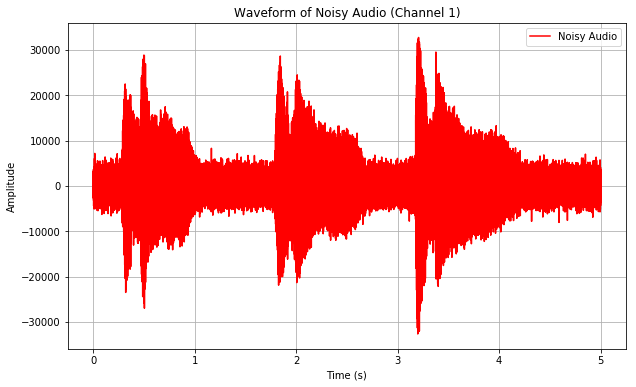

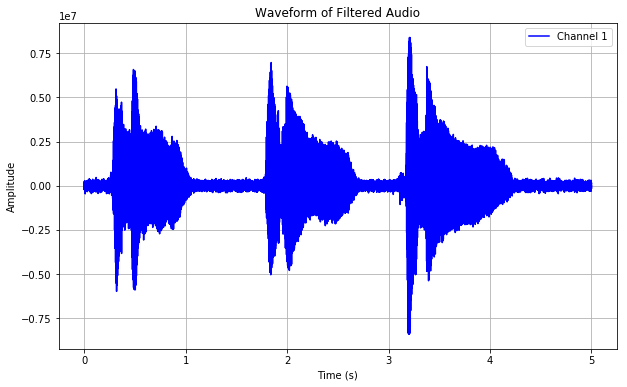

In [68]:
# Create a time axis for plotting the noisy audio
time_axis = np.linspace(0, len(single_channel_data) / framerate, num=len(single_channel_data))

# Plot the waveform of the noisy audio
plt.figure(figsize=(10, 6))
plt.plot(time_axis, noisy_audio_data, label='Noisy Audio', color='red')
plt.title('Waveform of Noisy Audio (Channel 1)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

# Create a time axis
time_axis = np.linspace(0, len(single_channel_data) / framerate, num=len(single_channel_data))

# Plot the waveform for a single channel
plt.figure(figsize=(10, 6))
plt.plot(time_axis, single_channel_data, label='Channel 1', color='blue')
plt.title('Waveform of Filtered Audio')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

In [61]:
#Examples of filtering
pAudio.load("noisy_audio.wav")
pAudio.play()

In [62]:
pAudio.load("filtered_audio.wav")
pAudio.play()

In [63]:
from IPython.display import Audio as IPAudio
IPAudio("noisy_audio.wav")

In [64]:
from IPython.display import Audio as IPAudio
IPAudio("filtered_audio.wav")

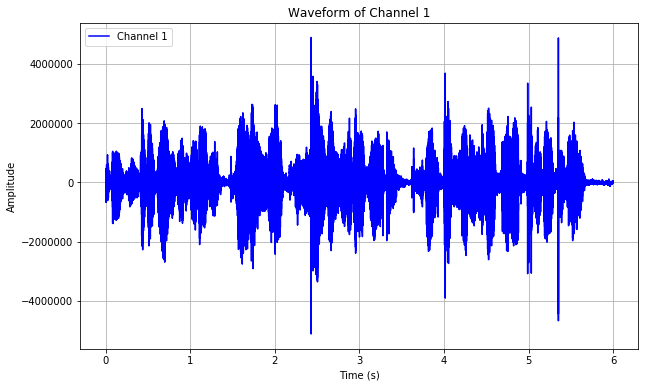

In [21]:
# Load the .wav file
with wave.open('filtered_audio.wav', 'rb') as wav_file:
    nchannels, sampwidth, framerate, nframes, comptype, compname = wav_file.getparams()
    frames = wav_file.readframes(nframes)

    # Process 24-bit audio
    if sampwidth == 3:  # For 24-bit
        audio_data = convert_24bit_to_int32(frames)
    else:  # For other bit depths
        dtype = np.int16 if sampwidth == 2 else np.int8
        audio_data = np.frombuffer(frames, dtype=dtype)
    
    # Reshape based on number of channels
    audio_data = audio_data.reshape(-1, nchannels)

# Select a single channel (e.g., channel 0)
single_channel_data = audio_data[:, 0]

# Create a time axis
time_axis = np.linspace(0, len(single_channel_data) / framerate, num=len(single_channel_data))

# Plot the waveform for a single channel
plt.figure(figsize=(10, 6))
plt.plot(time_axis, single_channel_data, label='Channel 1', color='blue')
plt.title('Waveform of Channel 1')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()